# Testing the sinkhole detectibility power
@author: Max Felius

## Roadmap - Determine Statistics and Errors from simulation
- Type I error: 
    - Apply least square to retrieve the 'scaling factor'
    - Extract ehat and determine the OMT
    - Test OMT with Chi2 distribution
- Type II error:
    - Determine detectability Power for each point
    
## Methodology
- The grid of the sinkhole is define. A number 'n' radii is defined. 
- 10 epochs are used to make data without a subsidence signal in it (thus only noise).
- A Linear model is fitted through all epochs (without subsidence signal) of each point to define the standard deviation of the noise and thus determine the noise level of each point ($\sigma_r$).
- New epochs are added to the dataframe with a subsidence signal in it. 
- The subsidence parameters are retrieved using the Best Linear Unbiased Estimator (BLUE).
    - For each new retrieval of the parameters, the previous measurements (with subsidence signal) are incorporated (i.e. the last BLUE estimation uses the most (all) measurements).
- An Overall Model Test is applied to look for type I errors.
- The Detectibility Power is determined by taking the subsidence and the noise sigma of a point per epoch.
    - Two Gaussian bell curves are define representing the null - and alternative hypothesis.
    - First curve (null hypothesis) has a mean=0 and $\sigma$=$\sigma_r$, second curve (alternative hypothesis) has a mean=$z_r$ and $\sigma$=$\sigma_r$.
    - Intersection between the two curves is computed.
    - Using the cumulative probability function, the area of the alternative hypothesis that does <strong>not</strong> overlap the null hypothesis curve is computed and defined as the 'Detectability Power'.
    
## NOTES
- Dataset will be stored in a pandas dataframe

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
from scipy.stats import chi2 #for chi2inv() function

In [2]:
def zg(R,r):
    return np.exp(-np.pi*(r**2/R**2))

def sinkhole_deformation(day,v,R,r,noise):
    return np.array([random.gauss(0,noise) for _ in range(len(r))]) + v*day*zg(R,r)

def linear_model(epochs,data):
    '''
    Function creating the linear model for detect arcs behaving anomalous
    '''
    
    #creating time vector
#     delta_days, start_day = get_delta_day(epochs)
    n_epochs = len(epochs)
    delta_days = np.array([x*12 for x in range(n_epochs)])
    start_day = 0
    
    
    #pre-allocate space for the output variables
    a = []
    b = []
    sigma_ehat = []
    
#     for i in range(len(data)):
#         '''
#         Loop creating a linear model per row
#         '''
        
    #setting up the system of equations
    y = np.array(data[epochs])
    A = np.array((delta_days,np.ones([len(delta_days)])))

    #stochastic matrix
    W = np.eye((len(y)))

    #compute solutions
    invW = np.linalg.inv(W)
    Qxhat = np.linalg.inv(A @ invW @ A.T)
    xhat = Qxhat @ A @ invW @ y

    yhat = A.T @ xhat
    ehat = y - yhat

    #compute the standard deviation of the noise of an arc
    sigma_ehat_out = np.sqrt((np.sum((ehat - np.mean(ehat))**2))/len(y))

    #saving the data
#     a.append(xhat[0])
#     b.append(xhat[1])
#     sigma_ehat.append(sigma_ehat_out)
    
    return xhat[0], xhat[1], sigma_ehat_out

def WLSE(R,r,y,t):
    w = np.eye(len(r))
    A = t*zg(R,r)
    
    Qxx = np.linalg.inv(A.T @ w @ A)
    xhat = Qxx @ A.T @ w @ y
    
#     yhat = A @ xhat
    return xhat

def BLUE(R,r,y,t,sigma):
    w = np.linalg.inv(np.eye(len(r))*sigma**2)
    A = t*zg(R,r)
    
    Qxx = np.linalg.inv(np.array(A.T @ w @ A).reshape((1,1)))
    
#     print(Qxx.shape,A.reshape((len(r),1)).T,w.shape,y.reshape((len(r),1)))
    
    A = A.reshape((len(r),1))
    y = y.reshape((len(r),1))

    xhat = Qxx @ A.T @ w @ y

    yhat = A @ xhat
    ehat = y - yhat
    return xhat, ehat

In [3]:
#Create cell to make point samples
#using the sinkhole from wink2016 for generating the point samples
v_wink2016_gaus = 0.00031 #[m/day]
R_wink2016_gaus = 555 # [m]
# delta_days = np.array([12, 24, 36, 48, 60, 72, 96, 108, 120, 132])
delta_days = np.array([12, 48, 96, 132])

#coordinates
x0 = 0
y0 = 0

#noise
mu = 0
sigma_noise = 0.003 # [m]
sigma = sigma_noise

#Define the sinkhole grid
n = 20
r = np.array([x**2 for x in range(n)])

In [4]:
# Create initialization set of epochs with only noise
header_init = ['Epoch 1','Epoch 2','Epoch 3','Epoch 4','Epoch 5','Epoch 6','Epoch 7','Epoch 8','Epoch 9','Epoch 10']
df = pd.DataFrame(np.zeros((n,len(header_init))),columns=header_init)

#create nxlen(header_init) array
for header in header_init:
    df[header] = [random.gauss(mu,sigma) for _ in range(n)]
    
#add the sigma of each row
df_sigma = pd.DataFrame(np.zeros((n,1)),columns=['Sigma_init [m]'])

for row in range(n):
    a, b, sigma_ehat = linear_model(header_init,df.iloc[row])
    df_sigma['Sigma_init [m]'].iloc[row] = sigma_ehat #np.std(df.iloc[row])
    
#join datasets
df = df_sigma.join(df)

#join radius
df_radius = pd.DataFrame(r.T,columns=['Radius [m]'])
df = df_radius.join(df)

#Create dataset with sinkhole signal
epochs = [str(x) for x in delta_days]
df_signal = pd.DataFrame(np.zeros((n,len(epochs))),columns=epochs)

for day in delta_days:
    df_signal[str(day)] = sinkhole_deformation(day,v_wink2016_gaus,R_wink2016_gaus,r,sigma)
    
#combine datasets
df = df.join(df_signal)

In [12]:
sigma_data = df['Sigma_init [m]'].values
R = 550
sigma = sigma_noise
t_array= np.array([])
r_array= np.array([])
y_array= np.array([])
sigma_array= np.array([])

xhat_save = []
ehat_save = np.zeros((n,len(delta_days)))

for idx, days in enumerate(delta_days):
    y = df[str(days)].values
    r = df['Radius [m]'].values
    t = np.array([days]*len(r))

    t_array = np.concatenate((t_array,t))
    y_array = np.concatenate((y_array,y))
    r_array = np.concatenate((r_array,r))
    
    xhat, ehat = BLUE(R,r_array,y_array,t_array,sigma)
#     xhat, ehat = BLUE(R,r,y,t,sigma)
    xhat_save.append(xhat[0][0])
#     ehat_save[:,idx] = ehat.reshape((n))

    #OMT - type I error
    sigma_array = np.concatenate((sigma_array,sigma_data))
    invQyy = np.linalg.inv(np.eye(len(sigma_array))*sigma_array)
    
    T = ehat.T @ invQyy @ ehat
    
    alpha = 0.05
    T_test = chi2.ppf(1-alpha,len(ehat))
    
    print('RMSE={:.01f} mm'.format(1000*np.sqrt(np.mean(ehat.T @ ehat))))
    print(f'Day: {delta_days[idx]}.','Reject Overall Model Test?:',(T > T_test)[0][0])

RMSE=11.1 mm
Day: 12. Reject Overall Model Test?: False
RMSE=15.8 mm
Day: 48. Reject Overall Model Test?: False
RMSE=20.8 mm
Day: 96. Reject Overall Model Test?: False
RMSE=24.9 mm
Day: 132. Reject Overall Model Test?: False


In [6]:
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

In [7]:
def detectability_power(sigma_in,z):
    m1 = 0
#     std1 = sigma
#     std2 = sigma
    dec_pow = []

    for sigma,m2 in zip(sigma_in,z_idx):
        std1 = sigma
        std2 = sigma
        result = solve(m1,m2,std1,std2)
        intersect = result[0]
        area = 1-(norm.cdf(intersect,m2,std2) + (1-norm.cdf(intersect,m1,std1)))
        dec_pow.append(area)
    return dec_pow

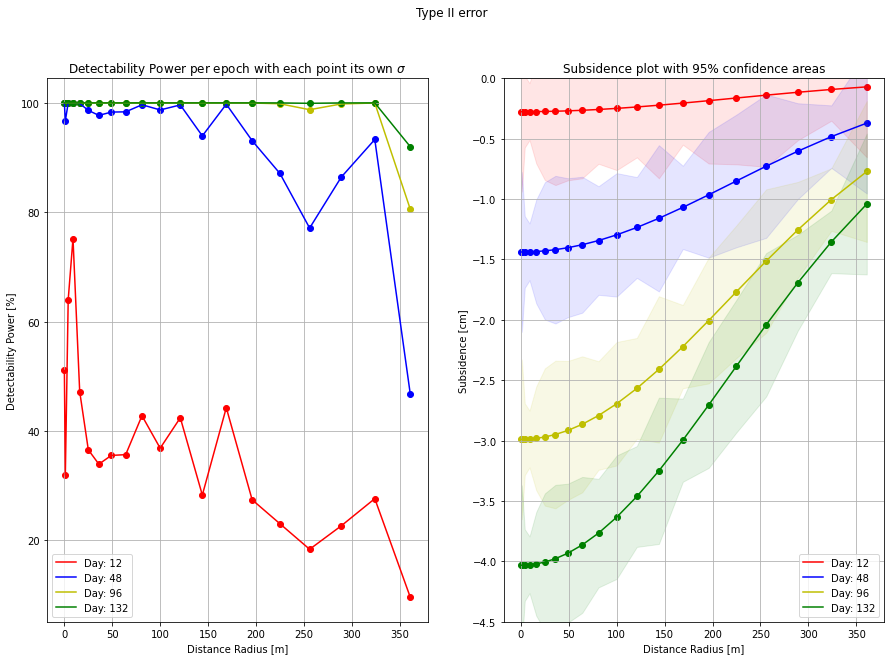

In [8]:
# plt.figure(figsize=(15,10))
sigma_data = df['Sigma_init [m]'].values*100
color = ['r','b','y','g']

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,10))

fig.suptitle('Type II error')

for i in range(len(xhat_save)):
    #zidx = i
    r = df['Radius [m]'].values
    z_idx = xhat_save[i]*delta_days[i]*zg(R,r)
    dec_pow2 = detectability_power(df['Sigma_init [m]'].values,z_idx)
    ax[0].plot(r,np.array(dec_pow2)*100,c=color[i],label='Day: {}'.format(delta_days[i]))
    ax[0].scatter(r,np.array(dec_pow2)*100,c=color[i])

ax[0].set_title('Detectability Power per epoch with each point its own $\sigma$')
ax[0].set_ylabel('Detectability Power [%]')
ax[0].set_xlabel('Distance Radius [m]')
ax[0].legend()
ax[0].grid(True);

# plt.figure(figsize=(15,10))

for idx,ixhat in enumerate(xhat_save):
    r = df['Radius [m]'].values
    z = -100*ixhat*delta_days[idx]*zg(R,r)
    ax[1].plot(r,z,c=color[idx],label=f'Day: {delta_days[idx]}')
    ax[1].scatter(r,z,c=color[idx])
    ax[1].fill_between(r, (z-1.96*sigma_data), (z+1.96*sigma_data), color=color[idx],alpha=.1)

ax[1].set_ylim([-4.5,0])
ax[1].set_title('Subsidence plot with 95% confidence areas')
ax[1].set_ylabel('Subsidence [cm]')
ax[1].set_xlabel('Distance Radius [m]')
ax[1].legend()
ax[1].grid(True);